Packages

In [1]:
import pandas as pd
import numpy as np
import functools
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Data Set

In [2]:
BITSTREAMVERA = pd.read_csv("https://raw.githubusercontent.com/CharlesColgan/MSDS-6350-6373-CODE/master/hw2/BITSTREAMVERA.csv")

CONSOLAS = pd.read_csv("https://raw.githubusercontent.com/CharlesColgan/MSDS-6350-6373-CODE/master/hw2/CONSOLAS.csv")

EBRIMA = pd.read_csv("https://raw.githubusercontent.com/CharlesColgan/MSDS-6350-6373-CODE/master/hw2/EBRIMA.csv")

Cleaning and Sorting

In [3]:
drop_names = ["fontVariant", "m_label", "orientation", "m_top", "m_left", "originalH", "originalW", "h", "w"]

CL1 = BITSTREAMVERA.dropna()

CL1.drop(columns = drop_names, inplace = True)

CL1.drop(CL1[(CL1["strength"] != 0.4) | (CL1["italic"] != 0)].index, inplace = True)

CL2 = CONSOLAS.dropna()

CL2.drop(columns = drop_names, inplace = True)

CL2.drop(CL2[(CL2["strength"] != 0.4) | (CL2["italic"] != 0)].index, inplace = True)

CL3 = EBRIMA.dropna()

CL3.drop(columns = drop_names, inplace = True)

CL3.drop(CL3[(CL3["strength"] != 0.4) | (CL3["italic"] != 0)].index, inplace = True)

DATA = pd.concat([CL1, CL2, CL3], ignore_index=True)

Standardize

In [4]:
for cl in [CL1, CL2, CL3]:
    cl[cl.columns[3:]] = pd.DataFrame(StandardScaler().fit_transform(cl[cl.columns[3:]]))
SDATA = pd.concat([CL1,CL2,CL3], ignore_index=True)

#PCA


correlation matrix

In [5]:
CORR = DATA[3:].corr()

eigenvalues/vectors

create new dataset

#re-classifying the new data

classes

assign selections ~20% of each class

define test&training sets

In [5]:
#create train/test set
train, test = train_test_split(SDATA, test_size=0.2, random_state=0)
x_train = train.drop(['font','strength','italic'], axis=1)
x_test = test.drop(['font','strength','italic'], axis=1)
y_train = train['font']
y_test = test['font']

#finding H0 and H*

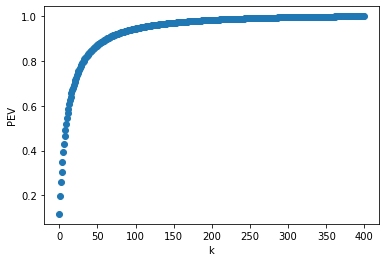

BITSTREAMVERA 



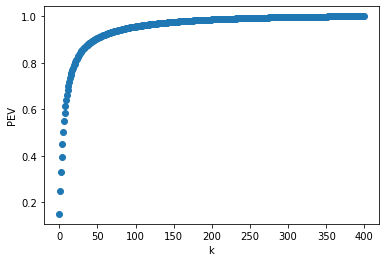

CONSOLAS 



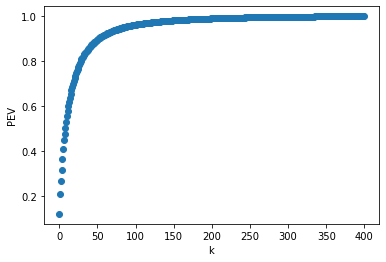

EBRIMA 



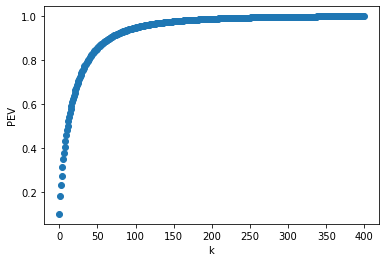

In [6]:
#H0:
pca = PCA(n_components=400)
pca.fit_transform(SDATA[SDATA.columns[3:]])
pev = pca.explained_variance_ratio_.cumsum()
h0 = np.where(pev>=0.95)[0][0]+1
plt.plot(pev, 'o'); plt.ylabel('PEV'); plt.xlabel('k'); plt.show() #plot PVE

#H*:
hi = []
for i in [CL1, CL2, CL3]:
  pca = PCA(n_components=400)
  pca.fit_transform(i[i.columns[3:]])
  pev = pca.explained_variance_ratio_.cumsum()
  hi.append(np.where(pev>=0.99)[0][0]+1)
  print(i['font'][0],'\n')
  plt.plot(pev, 'o'); plt.ylabel('PEV'); plt.xlabel('k'); plt.show() #plot PVE
h_star = sum(hi)

MLP0

MLP0:



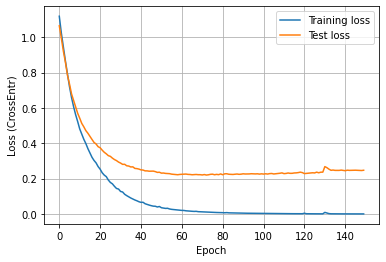

MLP0 train:
 Predicted      BITSTREAMVERA  CONSOLAS  EBRIMA
Actual                                        
BITSTREAMVERA            1.0       0.0     0.0
CONSOLAS                 0.0       1.0     0.0
EBRIMA                   0.0       0.0     1.0

MLP0 test:
 Predicted      BITSTREAMVERA  CONSOLAS    EBRIMA
Actual                                          
BITSTREAMVERA       0.984914  0.002004  0.006711
CONSOLAS            0.002155  0.875752  0.110738
EBRIMA              0.012931  0.122244  0.882550


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
tf.get_logger().setLevel('ERROR') #surpress logging 

def plotPerf(monitor):
  plt.plot(monitor.model.history.history['loss'], label='Training loss')
  plt.plot(monitor.model.history.history['val_loss'], label='Test loss')
  plt.xlabel('Epoch'); plt.ylabel('Loss (CrossEntr)')
  plt.legend(); plt.grid(True); plt.show()

def ypred(x, model):
  return list(map({0:'BITSTREAMVERA', 1:'CONSOLAS', 2:'EBRIMA'}.get, model.predict(x).argmax(axis=-1)))

def conf(actu, pred):
  y_actu = pd.Series(np.array(actu), name='Actual')
  y_pred = pd.Series(pred, name='Predicted')
  df_confusion = pd.crosstab(y_actu, y_pred)
  return df_confusion/ df_confusion.sum()

inputs = keras.Input(shape=(400,))
x1 = layers.Dense(h0,activation="sigmoid")(inputs)
outputs = layers.Dense(3, activation="softmax")(x1)
model0 = keras.Model(inputs=inputs,outputs=outputs)
#model0.summary()

optimizer = keras.optimizers.Adam()
loss_fn = keras.losses.SparseCategoricalCrossentropy()
model0.compile(optimizer=optimizer,loss=loss_fn, metrics=['accuracy'])
batch = round(len(train)**0.5)

checkpoint=callbacks.ModelCheckpoint(filepath='BestModel.h0',monitor='val_accuracy',save_best_only=True)
Monitor0 = model0.fit(x_train,y_train.astype('category').cat.codes,epochs=150, batch_size=batch,
                      validation_data=(x_test,y_test.astype('category').cat.codes),callbacks=[checkpoint], verbose=0)

print('MLP0:\n')
plotPerf(Monitor0) #visually find stabT, overfitT, stopT

trainConf0 = conf(y_train, ypred(x_train, model0))
print('MLP0 train:\n', trainConf0)
testConf0 = conf(y_test, ypred(x_test, model0))
print('\nMLP0 test:\n', testConf0)


MLP*

MLP*:



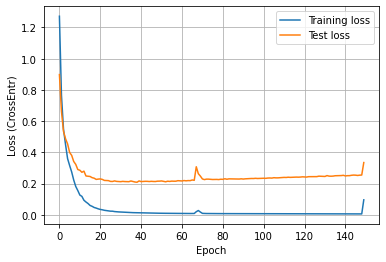

MLP* train:
 Predicted      BITSTREAMVERA  CONSOLAS    EBRIMA
Actual                                          
BITSTREAMVERA            1.0  0.002767  0.000711
CONSOLAS                 0.0  0.992252  0.014936
EBRIMA                   0.0  0.004981  0.984353

MLP* test:
 Predicted      BITSTREAMVERA  CONSOLAS    EBRIMA
Actual                                          
BITSTREAMVERA       0.987013  0.002183  0.008798
CONSOLAS            0.006494  0.899563  0.164223
EBRIMA              0.006494  0.098253  0.826979


In [8]:
#define sparsity regularization layer
class SparsityRegularizationLayer(layers.Layer):
  C = 0.01
  Tar = 0.01
  def call(self, inputs):
    avAL = tf.reduce_mean(inputs)
    self.add_loss(  self.C * (  -1*self.Tar*tf.math.log(avAL) + (self.Tar-1)*tf.math.log(1-avAL)  )  )
    return inputs

inputs = keras.Input(shape=(400,))
x1 = layers.Dense(h_star,activation="sigmoid")(inputs)
x1 = SparsityRegularizationLayer()(x1)
outputs = layers.Dense(3, activation="softmax")(x1)
modelh = keras.Model(inputs=inputs,outputs=outputs)
checkpoint=callbacks.ModelCheckpoint(filepath='BestModel.hstar',monitor='val_accuracy',save_best_only=True)

modelh.compile(optimizer=optimizer,loss=loss_fn, metrics=['accuracy'])
Monitorh = modelh.fit(x_train,y_train.astype('category').cat.codes,epochs=150, batch_size=batch,
                      validation_data=(x_test,y_test.astype('category').cat.codes),callbacks=[checkpoint], verbose=0)

print('MLP*:\n')
plotPerf(Monitorh) #visually find stabT, overfitT, stopT

trainConfh = conf(y_train, ypred(x_train, modelh))
print('MLP* train:\n', trainConfh)
testConfh = conf(y_test, ypred(x_test, modelh))
print('\nMLP* test:\n', testConfh)

#compare two sparsity levels?